## ReAct

In [34]:
# ReAct
from langchain import hub
from langchain.agents import AgentExecutor, create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import OpenAI
from dotenv import load_dotenv
load_dotenv()

True

In [35]:
tools = [TavilySearchResults(max_results=1)]
prompt = hub.pull("hwchase17/react")
print(prompt.template)

d:\anaconda3\envs\gpu-llm\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}


In [36]:
llm = OpenAI()
# Construct the ReAct agent
agent = create_react_agent(llm, tools, prompt)
# Create an agent executor by passing in the agent and tools
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [37]:
agent_executor.invoke({"input": "what is LangChain?"})



> Entering new AgentExecutor chain...
 LangChain is probably a term used in the tech or linguistics industry.
Action: tavily_search_results_json
Action Input: LangChain[{'url': 'https://python.langchain.com/docs/introduction/', 'content': "How to use tools in a chain How to migrate from legacy LangChain agents to LangGraph How to use chat models to call tools LangChain is a framework for developing applications powered by large language models (LLMs). Development: Build your applications using LangChain's open-source building blocks, components, and third-party integrations. langchain: Chains, agents, and retrieval strategies that make up an application's cognitive architecture. LangServe: Deploy LangChain chains as REST APIs. LangSmith: A developer platform that lets you debug, test, evaluate, and monitor LLM applications. Build stateful, multi-actor applications with LLMs. Integrates smoothly with LangChain, but can be used without it. LangChain is part of a rich ecosystem of tools

{'input': 'what is LangChain?',
 'output': 'LangChain is a framework for developing applications powered by large language models (LLMs), which includes various components, integrations, and agents. Its official documentation provides detailed information on how to use LangChain and its various features.'}

## Function calling

In [26]:
import json
from openai import OpenAI
from tenacity import retry, wait_random_exponential, stop_after_attempt
GPT_MODEL = "gpt-4o"
client = OpenAI()

In [27]:
@retry(wait=wait_random_exponential(multiplier=1, max=40), stop=stop_after_attempt(3))
def chat_completion_request(messages, tools=None, tool_choice=None, model=GPT_MODEL):
    try:
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            tools=tools,
            tool_choice=tool_choice,
        )
        return response
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e

In [28]:
import sqlite3

conn = sqlite3.connect("Chinook.db")
print("Opened database successfully")

def get_table_names(conn):
    """Return a list of table names."""
    table_names = []
    tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
    for table in tables.fetchall():
        table_names.append(table[0])
    return table_names


def get_column_names(conn, table_name):
    """Return a list of column names."""
    column_names = []
    columns = conn.execute(f"PRAGMA table_info('{table_name}');").fetchall()
    for col in columns:
        column_names.append(col[1])
    return column_names


def get_database_info(conn):
    """Return a list of dicts containing the table name and columns for each table in the database."""
    table_dicts = []
    for table_name in get_table_names(conn):
        columns_names = get_column_names(conn, table_name)
        table_dicts.append({"table_name": table_name, "column_names": columns_names})
    return table_dicts

Opened database successfully


In [29]:
database_schema_dict = get_database_info(conn)
database_schema_string = "\n".join(
    [
        f"Table: {table['table_name']}\nColumns: {', '.join(table['column_names'])}"
        for table in database_schema_dict
    ]
)

In [30]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "ask_database",
            "description": "Use this function to answer user questions about music. Input should be a fully formed SQL query.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": f"""
                                SQL query extracting info to answer the user's question.
                                SQL should be written using this database schema:
                                {database_schema_string}
                                The query should be returned in plain text, not in JSON.
                                """,
                    }
                },
                "required": ["query"],
            },
        }
    }
]

In [31]:
def ask_database(conn, query):
    """Function to query SQLite database with a provided SQL query."""
    try:
        results = str(conn.execute(query).fetchall())
    except Exception as e:
        results = f"query failed with error: {e}"
    return results

In [32]:
# Step #1: Prompt with content that may result in function call. In this case the model can identify the information requested by the user is potentially available in the database schema passed to the model in Tools description. 
messages = [{
    "role":"user", 
    "content": "What is the name of the album with the most tracks?"
}]

response = client.chat.completions.create(
    model='gpt-4o', 
    messages=messages, 
    tools= tools, 
    tool_choice="auto"
)

# Append the message to messages list
response_message = response.choices[0].message 
messages.append(response_message)

print(response_message)

ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_JgpDWKuQCCASA0U484pYZEQx', function=Function(arguments='{"query":"SELECT Album.Title, COUNT(Track.TrackId) AS TrackCount FROM Album JOIN Track ON Album.AlbumId = Track.AlbumId GROUP BY Album.AlbumId ORDER BY TrackCount DESC LIMIT 1;"}', name='ask_database'), type='function')])


In [33]:
# Step 2: determine if the response from the model includes a tool call.   
tool_calls = response_message.tool_calls
if tool_calls:
    # If true the model will return the name of the tool / function to call and the argument(s)  
    tool_call_id = tool_calls[0].id
    tool_function_name = tool_calls[0].function.name
    tool_query_string = json.loads(tool_calls[0].function.arguments)['query']

    # Step 3: Call the function and retrieve results. Append the results to the messages list.      
    if tool_function_name == 'ask_database':
        results = ask_database(conn, tool_query_string)
        
        messages.append({
            "role":"tool", 
            "tool_call_id":tool_call_id, 
            "name": tool_function_name, 
            "content":results
        })
        
        # Step 4: Invoke the chat completions API with the function response appended to the messages list
        # Note that messages with role 'tool' must be a response to a preceding message with 'tool_calls'
        model_response_with_function_call = client.chat.completions.create(
            model="gpt-4o",
            messages=messages,
        )  # get a new response from the model where it can see the function response
        print(model_response_with_function_call.choices[0].message.content)
    else: 
        print(f"Error: function {tool_function_name} does not exist")
else: 
    # Model did not identify a function to call, result can be returned to the user 
    print(response_message.content) 

The album with the most tracks is "Greatest Hits," which has 57 tracks.


## Reflexion Agent

Actor (with reflection)

The main component of Reflexion is the "actor", which is an agent that reflects on its response and re-executes to improve based on self-critique. It's main sub-components include:

Tools/tool execution
Initial responder: generate an initial response (and self-reflection)
Revisor: re-respond (and reflec) based on previous reflections
We'll first define the tool execution context.

In [ ]:
!pip install -U --quiet langgraph langchain_anthropic tavily-python langchain_community langchain_openai

In [16]:
# construct tools
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()

llm = ChatOpenAI(model='gpt-4o-mini')
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=1)

Initial responder

Using Pydantic with LangChain

In [17]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import ValidationError

from pydantic import BaseModel, Field


class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )


class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: dict):
        response = []
        for attempt in range(3):
            response = self.runnable.invoke(
                {"messages": state["messages"]}, {"tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return {"messages": response}
            except ValidationError as e:
                state = state + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + self.validator.schema_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return {"messages": response}

In [18]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

In [19]:
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""


# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

In [22]:
from langchain_core.tools import StructuredTool
from langgraph.prebuilt import ToolNode

def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

In [23]:
from typing import Literal

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


MAX_ITERATIONS = 5
builder = StateGraph(State)
builder.add_node("draft", first_responder.respond)


builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)
# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list):
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state["messages"])
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop, ["execute_tools", END])
builder.add_edge(START, "draft")
graph = builder.compile()

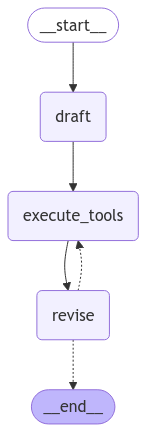

In [24]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
events = graph.stream(
    {"messages": [("user", "How should we handle the climate crisis?")]},
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step["messages"][-1].pretty_print()

Step 0
================================ Human Message =================================

How should we handle the climate crisis?
Step 1
================================== Ai Message ==================================
Tool Calls:
  AnswerQuestion (call_72yL4OFN1M2vVIIcvSz12CJd)
 Call ID: call_72yL4OFN1M2vVIIcvSz12CJd
  Args:
    answer: Handling the climate crisis requires a multifaceted strategy that encompasses immediate action, long-term planning, and collaboration across various sectors. First, reducing greenhouse gas emissions is critical. This can be achieved by transitioning to renewable energy sources such as solar, wind, and hydro, while phasing out fossil fuels. Governments can implement policies that incentivize clean energy and penalize carbon emissions, thus promoting sustainable practices.

Second, reforestation and conservation efforts should be prioritized to enhance carbon sequestration. Protecting existing forests and restoring degraded landscapes can significantly im